In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

c:\Users\Yash\Desktop\LangGraph\langgraph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
class SubState(TypedDict):

    input_text: str
    translated_text: str

In [4]:
subgraph_llm =  ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite')

In [5]:
def translate_text(state: SubState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["input_text"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'translated_text': translated_text}

In [6]:
subgraph_builder = StateGraph(SubState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

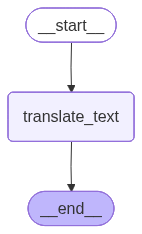

In [7]:
subgraph

In [8]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str
    

In [9]:
parent_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite')

In [10]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [11]:
def translate_answer(state: ParentState):

    # call the subgraph
    result = subgraph.invoke({'input_text': state['answer_eng']})

    return {'answer_hin': result['translated_text']}

In [12]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", translate_answer)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

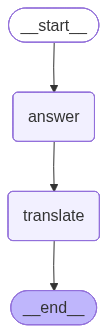

In [13]:
graph = parent_builder.compile()

graph

In [14]:
graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': 'Quantum physics is a **fundamental theory in physics that describes the behavior of nature at the smallest scales of energy and matter**, such as atoms and subatomic particles. It\'s fundamentally different from classical physics, which describes the macroscopic world we experience daily.\n\nHere are the key concepts that define quantum physics:\n\n*   **Quantization:** Many physical properties that were thought to be continuous in classical physics, like energy, momentum, and angular momentum, are found to be **quantized**. This means they can only exist in discrete, specific amounts, like steps on a ladder rather than a smooth ramp. For example, electrons in atoms can only occupy specific energy levels.\n\n*   **Wave-Particle Duality:** One of the most counterintuitive concepts is that **particles can behave like waves, and waves can behave like particles**. An electron, for instance, can exhibit wave-like properties like interf